# Експеремент перший

Створюємо модель для роботи з moons

In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

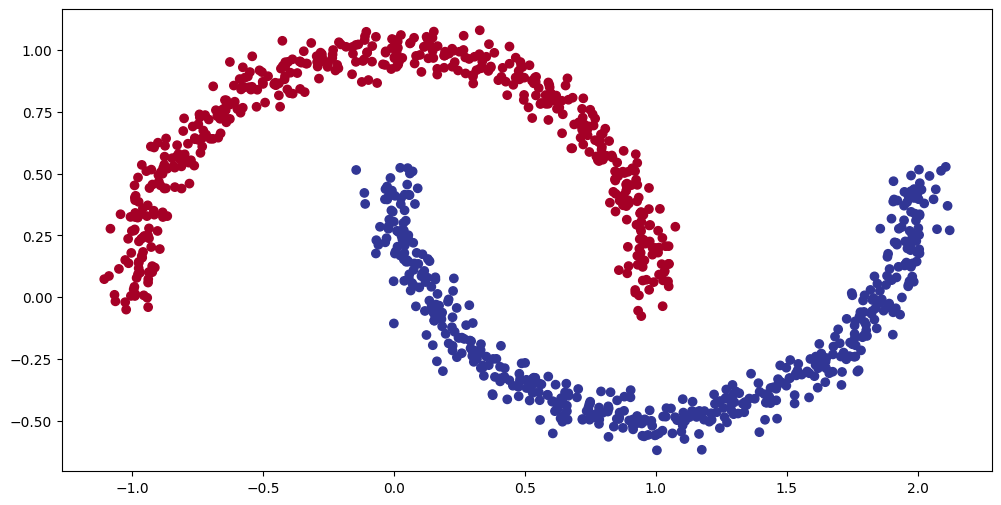

In [4]:
n_samples = 1000

X, y = make_moons(n_samples, noise=0.05, random_state=42)

plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))

moon_model = MoonsModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model.parameters(), lr=0.1)

def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Epoch: 10 | Loss: 0.23045, Accuracy: 89.12% | Test loss: 0.23211, Test acc: 89.50%
Epoch: 20 | Loss: 0.22982, Accuracy: 89.12% | Test loss: 0.23139, Test acc: 89.50%
Epoch: 30 | Loss: 0.22922, Accuracy: 89.12% | Test loss: 0.23071, Test acc: 89.50%
Epoch: 40 | Loss: 0.22865, Accuracy: 89.12% | Test loss: 0.23007, Test acc: 89.50%
Epoch: 50 | Loss: 0.22810, Accuracy: 89.50% | Test loss: 0.22946, Test acc: 89.50%
Epoch: 60 | Loss: 0.22758, Accuracy: 89.50% | Test loss: 0.22888, Test acc: 89.50%
Epoch: 70 | Loss: 0.22706, Accuracy: 89.50% | Test loss: 0.22833, Test acc: 89.50%
Epoch: 80 | Loss: 0.22657, Accuracy: 89.50% | Test loss: 0.22781, Test acc: 90.00%
Epoch: 90 | Loss: 0.22609, Accuracy: 89.50% | Test loss: 0.22730, Test acc: 90.00%
Epoch: 100 | Loss: 0.22563, Accuracy: 89.38% | Test loss: 0.22681, Test acc: 90.00%
Epoch: 110 | Loss: 0.22517, Accuracy: 89.38% | Test loss: 0.22634, Test acc: 90.00%
Epoch: 120 | Loss: 0.22473, Accuracy: 89.38% | Test loss: 0.22590, Test acc: 89.50%
E

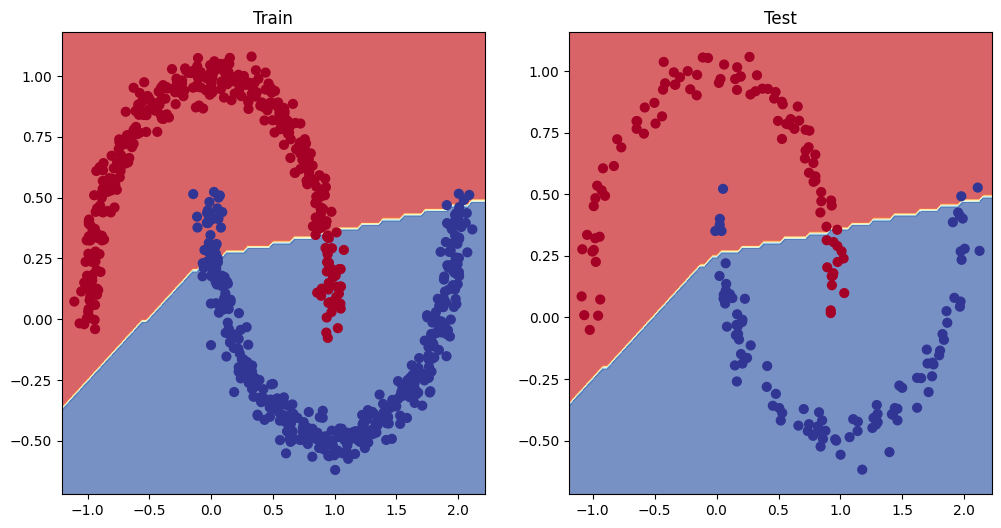

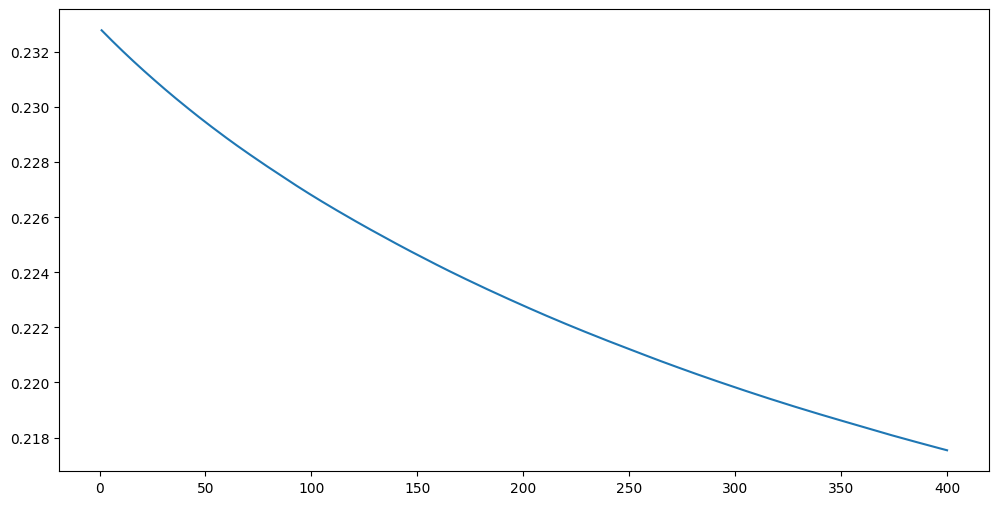

In [12]:
torch.manual_seed(23)

epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    moon_model.train()

    y_logits = moon_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon_model.eval()
    with torch.inference_mode():

        test_logits = moon_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)
plt.savefig("first.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.savefig("first_loss.png")

# Результат першого експеременту

З першого тесту бачимо, що модель працює доволі не погано на наших параметрах.

Спробуємо змінити функцію активації, збільшити learning rate та збільшити ширину нейронів.

Epoch: 10 | Loss: 0.31168, Accuracy: 84.38% | Test loss: 0.32067, Test acc: 83.50%
Epoch: 20 | Loss: 0.26590, Accuracy: 87.25% | Test loss: 0.26968, Test acc: 87.50%
Epoch: 30 | Loss: 0.25169, Accuracy: 87.62% | Test loss: 0.25152, Test acc: 88.50%
Epoch: 40 | Loss: 0.24721, Accuracy: 88.25% | Test loss: 0.24483, Test acc: 89.50%
Epoch: 50 | Loss: 0.24563, Accuracy: 88.88% | Test loss: 0.24204, Test acc: 89.50%
Epoch: 60 | Loss: 0.24493, Accuracy: 89.00% | Test loss: 0.24069, Test acc: 89.50%
Epoch: 70 | Loss: 0.24452, Accuracy: 88.88% | Test loss: 0.23996, Test acc: 89.50%
Epoch: 80 | Loss: 0.24423, Accuracy: 88.88% | Test loss: 0.23951, Test acc: 89.00%
Epoch: 90 | Loss: 0.24399, Accuracy: 88.88% | Test loss: 0.23922, Test acc: 89.00%
Epoch: 100 | Loss: 0.24379, Accuracy: 88.88% | Test loss: 0.23901, Test acc: 89.00%
Epoch: 110 | Loss: 0.24362, Accuracy: 88.88% | Test loss: 0.23885, Test acc: 89.00%
Epoch: 120 | Loss: 0.24347, Accuracy: 88.88% | Test loss: 0.23873, Test acc: 89.00%
E

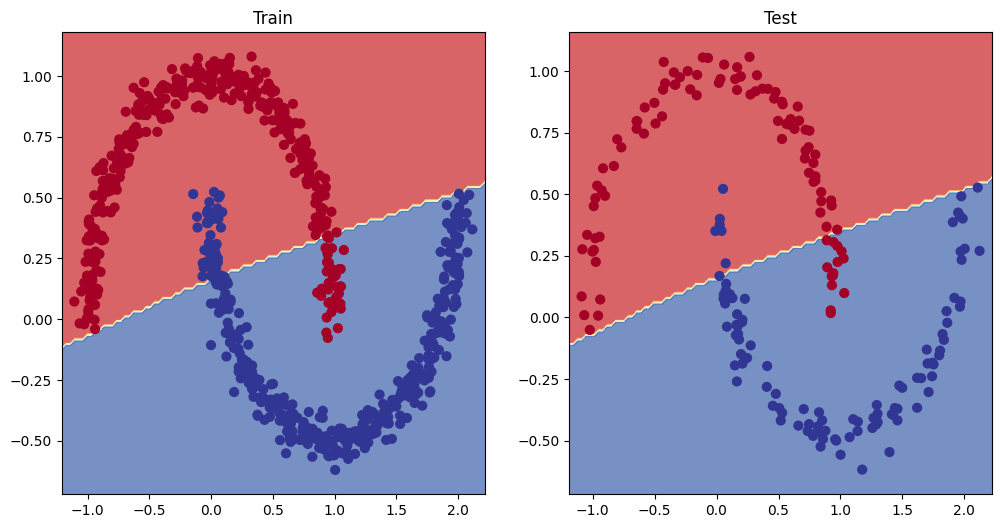

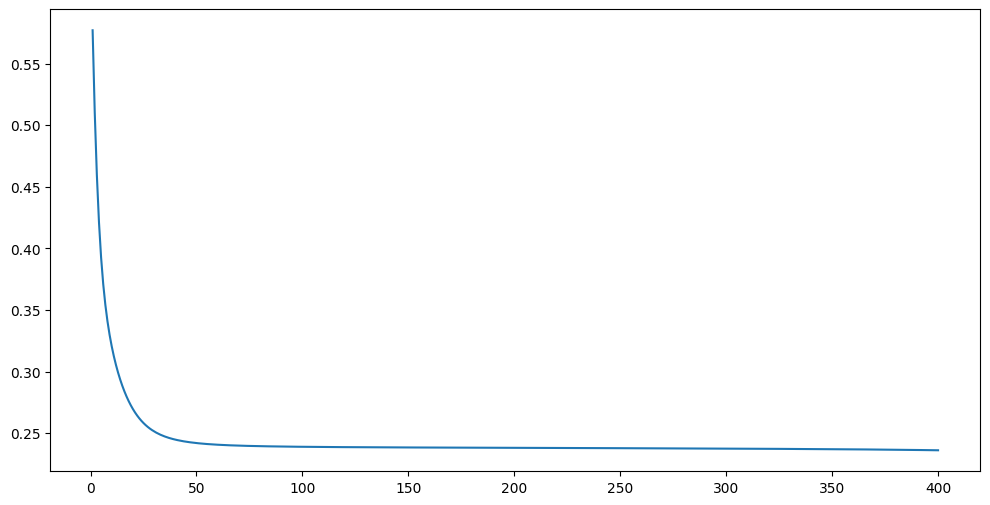

In [13]:
class MoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=11)
        self.layer_2 = nn.Linear(in_features=11, out_features=1)
        self.elu = nn.ELU()

    def forward(self, x):
        return self.layer_2(self.elu(self.layer_1(x)))

moon_model = MoonsModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model.parameters(), lr=1)

torch.manual_seed(23)

epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    moon_model.train()

    y_logits = moon_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon_model.eval()
    with torch.inference_mode():

        test_logits = moon_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)
plt.savefig("second.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.savefig("second_loss.png")

# Другий експеремент

Особливих змін не спостерігається.

Спробуємо іншу функцію активації.

Epoch: 10 | Loss: 0.31057, Accuracy: 85.12% | Test loss: 0.31781, Test acc: 84.00%
Epoch: 20 | Loss: 0.26438, Accuracy: 87.50% | Test loss: 0.26688, Test acc: 88.00%
Epoch: 30 | Loss: 0.25174, Accuracy: 88.25% | Test loss: 0.25110, Test acc: 89.00%
Epoch: 40 | Loss: 0.24809, Accuracy: 88.62% | Test loss: 0.24574, Test acc: 89.50%
Epoch: 50 | Loss: 0.24683, Accuracy: 88.50% | Test loss: 0.24353, Test acc: 89.50%
Epoch: 60 | Loss: 0.24625, Accuracy: 88.62% | Test loss: 0.24246, Test acc: 89.00%
Epoch: 70 | Loss: 0.24589, Accuracy: 88.88% | Test loss: 0.24185, Test acc: 89.00%
Epoch: 80 | Loss: 0.24560, Accuracy: 88.88% | Test loss: 0.24145, Test acc: 89.50%
Epoch: 90 | Loss: 0.24533, Accuracy: 88.88% | Test loss: 0.24116, Test acc: 89.50%
Epoch: 100 | Loss: 0.24506, Accuracy: 88.88% | Test loss: 0.24092, Test acc: 89.50%
Epoch: 110 | Loss: 0.24476, Accuracy: 88.88% | Test loss: 0.24069, Test acc: 89.50%
Epoch: 120 | Loss: 0.24444, Accuracy: 88.88% | Test loss: 0.24045, Test acc: 89.50%
E

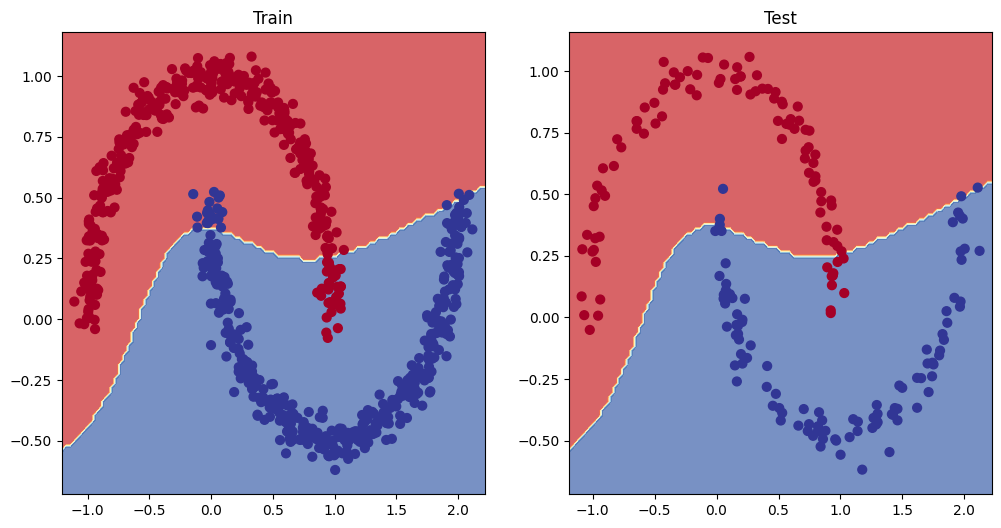

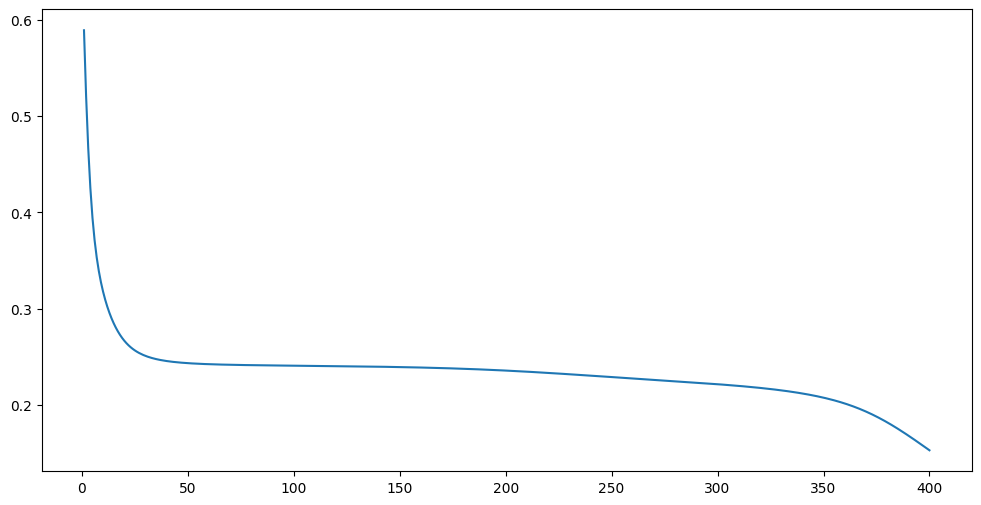

In [14]:
class MoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=11)
        self.layer_2 = nn.Linear(in_features=11, out_features=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        return self.layer_2(self.tanh(self.layer_1(x)))

moon_model = MoonsModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model.parameters(), lr=1)

torch.manual_seed(23)

epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    moon_model.train()

    y_logits = moon_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon_model.eval()
    with torch.inference_mode():

        test_logits = moon_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)
plt.savefig("third.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.savefig("third_loss.png")

# Результат третього експеременту

З цією функцією є помітне покращення в результатах.

Далі експерементуємо з нейроними слоями, епохами та learning rate.

Epoch: 10 | Loss: 0.31461, Accuracy: 84.50% | Test loss: 0.29202, Test acc: 87.00%
Epoch: 20 | Loss: 0.25531, Accuracy: 89.00% | Test loss: 0.27917, Test acc: 86.50%
Epoch: 30 | Loss: 0.26226, Accuracy: 87.88% | Test loss: 0.25064, Test acc: 88.50%
Epoch: 40 | Loss: 0.26740, Accuracy: 87.50% | Test loss: 0.24595, Test acc: 88.50%
Epoch: 50 | Loss: 0.25085, Accuracy: 88.88% | Test loss: 0.22021, Test acc: 92.00%
Epoch: 60 | Loss: 0.16304, Accuracy: 95.00% | Test loss: 0.12262, Test acc: 96.00%
Epoch: 70 | Loss: 0.05050, Accuracy: 99.62% | Test loss: 0.04655, Test acc: 100.00%
Epoch: 80 | Loss: 0.02930, Accuracy: 100.00% | Test loss: 0.02762, Test acc: 100.00%
Epoch: 90 | Loss: 0.02044, Accuracy: 100.00% | Test loss: 0.01934, Test acc: 100.00%
Epoch: 100 | Loss: 0.01557, Accuracy: 100.00% | Test loss: 0.01474, Test acc: 100.00%


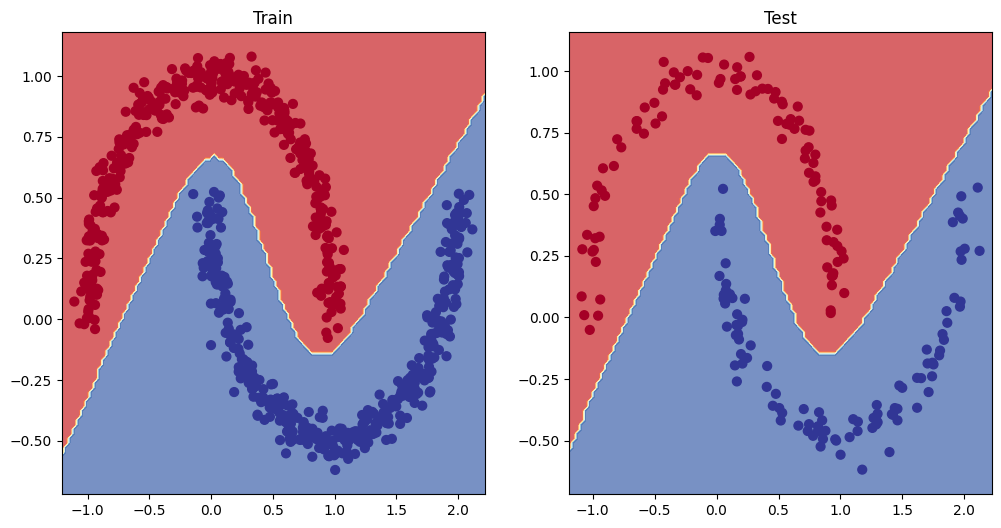

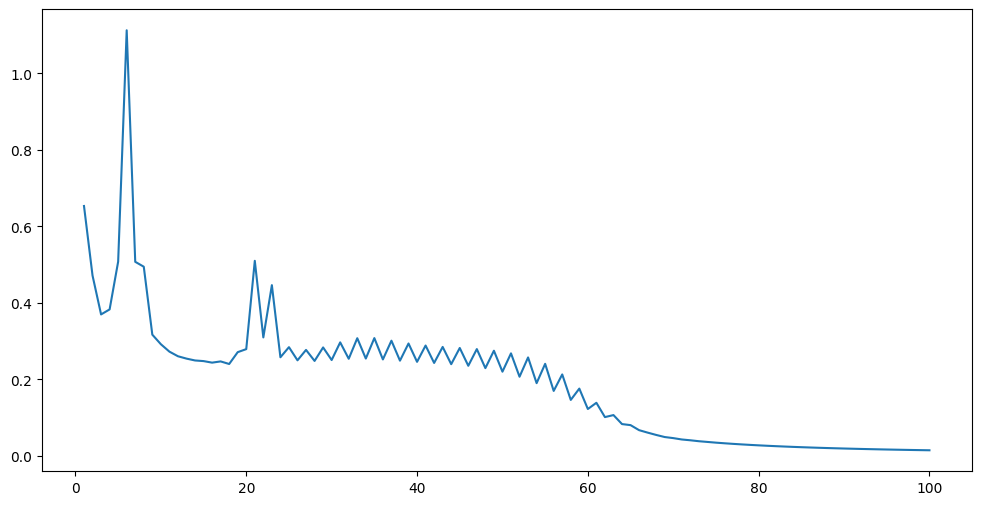

In [25]:
class MoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=3)
        self.layer_2 = nn.Linear(in_features=3, out_features=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        return self.layer_2(self.tanh(self.layer_1(x)))

moon_model = MoonsModel().to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moon_model.parameters(), lr=6)

torch.manual_seed(23)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_list = []

for epoch in range(1, epochs+1):

    moon_model.train()

    y_logits = moon_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fun(y_logits, y_train)
    acc = accuracy_fun(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon_model.eval()
    with torch.inference_mode():

        test_logits = moon_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy_fun(y_test, test_pred)
        loss_list.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)
plt.savefig("fourth.png")
plt.figure(figsize=(12,6))
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.savefig("fourth_loss.png")

# Висновки

Після останнього експеременту бачимо, що:

- Найкраща функція активації - tanh
- Достатньо двох слоїв, де другий має лише 3 фічі
- Learning rate доволі великий - 6
- Достатньо 100 епох, щоб побачити результат

Вже на 70 епосі модель досягає 100% результату. Проте оптимально мати 80 епох, після них вже похибка змінюється відносно малими кроками.